In [1]:
# required Python imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from skimage import measure

from scipy.spatial.transform import Rotation as rot
from scipy.optimize import minimize

The aim of this notebook is to generate a function, or alternatively a database, which given an orientation and transmission values returns:

- The orientation in Euler angles
- the coordinates of the points (x, y) in the XY plane (z=0)
- the transmissión values (i.e. the length of the vector)
- the angle respect to the polarizer

This will serve to test the procedure that estimate the crystal orientation using FTIR data.

In [2]:
def Tvalues(trans, theta, phi):
    """ Calculates the transmission value for any direction in polar
    coordinates using the equation (5) of Asimov et al. (2006) for a
    especific wavelength ignoring the sample thickness (i.e. =1).

    Parameters
    ----------
    trans : a tuple of size 3
        tuple containeing the transmission values along a-axis (Ta),
        b-axis (Tb), and c-axis (Tc). -> (Ta, Tb, Tc)
    theta : int or float between 0 and pi/2
        angle respect to the c-axis in radians
    phi : int or float between 0 and 2*pi
        angle respect to the a-axis in radians

    Returns
    -------
    numpy array
        the calculated T values for any given orientation
    """

    # extract Tx values
    Ta, Tb, Tc = trans
    
    return Ta * np.cos(phi)**2 * np.sin(theta)**2 + \
           Tb * np.sin(phi)**2 * np.sin(theta)**2 + \
           Tc * np.cos(theta)**2


def sph2cart(r, phi, theta=np.deg2rad(90)):
    """ Convert from spherical/polar (magnitude, thetha, phi) to
    cartesian coordinates. Phi and theta angles are as used in
    physics (ISO 80000-2:2019) and in radians. If theta is not given,
    the point is assumed to lie on the XY plane.

    Parameters
    ----------
    r : int, float or array
        radial distance (magnitud of the vector)
    phi : int, float or array with values between 0 and 2*pi
        azimuth angle respect to the x-axis direction in radians
    theta : int, float or array with values between 0 and pi/2,
        polar angle respect to the zenith (z) direction in radians
        optional
    
    Returns
    -------
    numpy ndarrays (1d)
        three numpy 1d arrays with the cartesian x, y, and z coordinates
    """
    
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return np.around(x, decimals=6), np.around(y, decimals=6), np.around(z, decimals=6)


def cart2sph(x, y, z):
    """Converts from 3D cartesian to spherical coordinates.

    Parameters
    ----------
    x : int, float or array
        The x-coordinate(s) in Cartesian space.
    y : int, float or array
        The y-coordinate(s) in Cartesian space.
    z : int, float or array
        The z-coordinate(s) in Cartesian space.

    Returns
    -------
    tuple of floats
        A tuple containing the polar coordinates (r, theta, phi) of the input Cartesian point,
        where r is the distance from the origin to the point, theta is the polar angle from the
        positive z-axis, and phi is the azimuthal angle from the positive x-axis (ISO 80000-2:2019).
    """
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z / r)
    phi = np.arctan2(y, x)  # calculates the arctangent with the correct sign to handle all quadrants

    return (r, phi, theta)


def rotate(coordinates, euler_ang):
    """ Rotate points in 3D cartesian space using the Bunge convention
    in degrees with intrinsic rotation. This is just a wrapper for the
    r.from_euler() Scipy method for convenience

    Parameters
    ----------
    coordinates : tuple of size 3
        a tuple containing the cartesian coordinates of this form:
        (x, y, z). variables x, y and z can be scalars or arrays.
    euler_ang : tuple of size 3
        a tuple containing the three euler angles in degrees
        using Bunge convention -> (z, x, z)

    Returns
    -------
    three numpy arrays containing the x, y, z coordinates respectively
    
    Example
    -------
    x, y, z = rotate(coordinates=(x, y, z), euler_ang=(30, 0, 40))
    """
    # create a ndarray to vectorize the rotation operation
    coordinates = np.dstack(coordinates)

    # define a rotation in euler space (Bunge) for intrinsic rotations
    rotation = rot.from_euler('zxz', [euler_ang[0], euler_ang[1], euler_ang[2]], degrees=True)

    # apply rotation
    new_coordinates = coordinates @ rotation.as_matrix().T

    return new_coordinates[:,:,0], new_coordinates[:,:,1], new_coordinates[:,:,2]


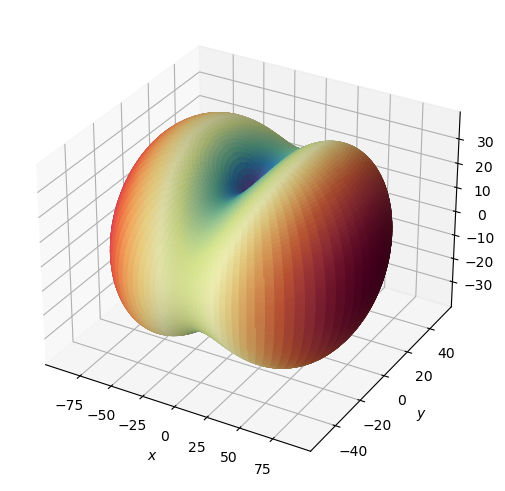

In [45]:
# generate spherical/polar coordinates
phi = np.linspace(0, 2*np.pi, 100)
theta = np.arccos(1 - 2 * np.linspace(0, 1, 100))  # phi = arcos(1 - 2x) in this case np.linspace goes from 0 to 1 (not pi)!*
theta, phi = np.meshgrid(theta, phi)

# estimate T values
T = Tvalues(trans=(90, 50, 20), theta=theta, phi=phi)

# convert from spherical to cartesian coordinates
x, y, z = sph2cart(T, phi, theta)

# normalize colors for T values to max and min values
Tmax, Tmin = T.max(), T.min()
Tcolors = (T - Tmin) / (Tmax - Tmin)

# make figure
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, constrained_layout=True)

ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=cm.Spectral_r(Tcolors))
_ = ax.set_xlabel(r'$x$'), ax.set_ylabel(r'$y$'), ax.set_zlabel(r'$z$')

## JAPN approach: using matplolib contour

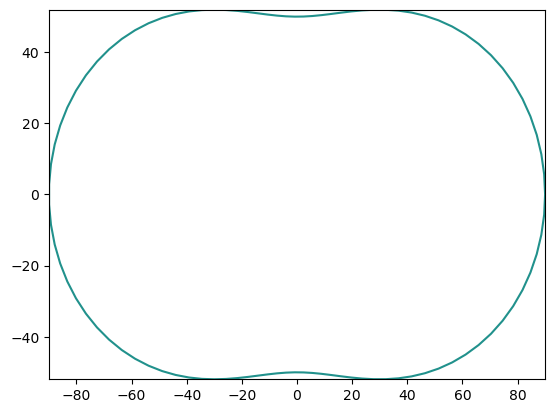

In [46]:
section_xy = plt.contour(x, y, z, levels=0)

In [47]:
def XY_section(x, y, z):
    
    # estimate the contour at z=0 (i.e. XY plane)
    section_xy = plt.contour(x, y, z, levels=[0])

    # get the vertice coordinates (array-like)
    coordinates = section_xy.allsegs[0][0]

    # get vector lengths (i.e. T values within the XY plane)
    T = np.linalg.norm(coordinates, axis=1)

    # get the angle of the vector (in radians)
    angles = np.arctan2(coordinates[:, 1], coordinates[:, 0])

    # Convert angles to the range 0-2π (0-360 degrees)
    angles = np.degrees(angles) % 360

    # Convert angles to the range 0-360 degrees clockwise
    angles = (90 - angles) % 360

    df = pd.DataFrame({
        'x': coordinates[:, 0],
        'y': coordinates[:, 1],
        'T': T,
        'angles': angles
    })

    return df

,x,y,T,angles
0,89.988267,0.000000,89.988267,90.000000
1,89.646536,5.697205,89.827388,86.363636
2,88.628523,11.310699,89.347339,82.727273
3,86.955525,16.759304,88.555845,79.090909
4,84.662253,21.966820,87.465640,75.454545
...,...,...,...,...
95,84.662253,-21.966820,87.465640,104.545455
96,86.955525,-16.759304,88.555845,100.909091
97,88.628523,-11.310699,89.347339,97.272727
98,89.646536,-5.697205,89.827388,93.636364


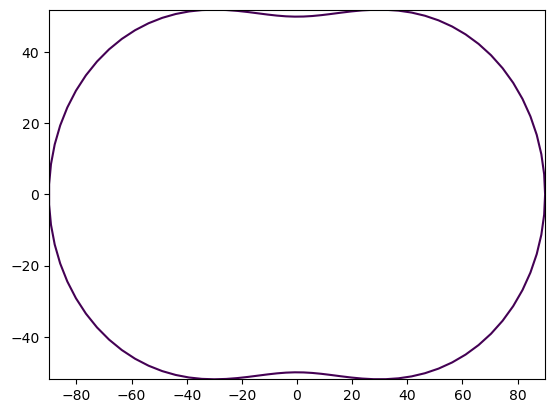

In [48]:
data = XY_section(x, y, z)
data

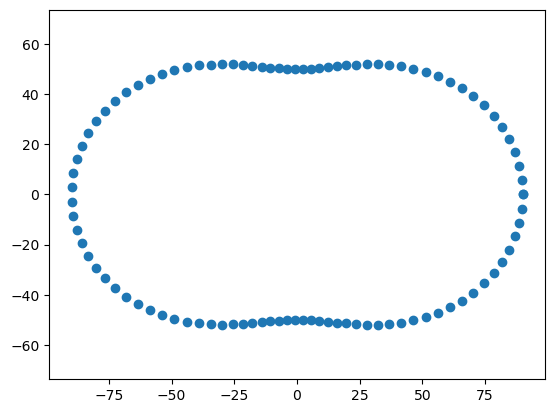

In [49]:
plt.plot(data['x'], data['y'], 'o')
_ = plt.axis('equal')

In [50]:
# sort values based on angle respect to polarizer
data = data.sort_values(by=['angles']).reset_index()
data

,index,x,y,T,angles
0,24,2.383137,50.028207,50.084936,2.727272
1,23,5.595746,50.174648,50.485718,6.363636
2,22,8.890848,50.422503,51.200351,10.000000
3,21,12.310704,50.745414,52.217339,13.636363
4,20,15.891273,51.106671,53.520317,17.272728
...,...,...,...,...,...
95,29,-14.078954,50.923912,52.834286,344.545454
96,28,-10.582762,50.576643,51.671962,348.181819
97,27,-7.230221,50.287289,50.804405,351.818181
98,26,-3.981959,50.087539,50.245573,355.454546


## Weak points

It is possible to extract an array of coordinates using matplotlib contour and calculate the other variables from them, but the following problems arise:

- A figure is created each time this method is used. This would not be a major disadvantage if the goal is to create a database for later use as a test of the method. If it is to be done interactively, this is a major impediment (as it would make everything very slow and cumbersome).
- We can control the density of points increasing the 3d mesh, the contour methods calculates the same number of points as the original 3d mesh (in this case 100), but we cannot control whether we want a point every degree or half a degree. This is a major impediment as for example we may be interested in obtaining three points at angles 0, 45 and 90 and this is not possible to do (note that the first point starts at an angle of 2.73 with respect to the y-axis for 100 points).

---

The contour method uses the marching squares algorithm to generate the contours. This algorithm is also implemented in scikit-image without generating a plot each time is called. Seehttps://scikit-image.org/docs/stable/auto_examples/edges/plot_contours.html

An implementation using this would be as follows:

In [54]:
def XY_section(x, y, z):
    # Find the contour lines at z=0
    contours = measure.find_contours(z, level=0)

    # Extract the coordinates of the contour line
    coordinates = contours[0]

    # Calculate vector lengths (T values)
    T = np.linalg.norm(coordinates, axis=1)

   # get the angle of the vector (in radians)
    angles = np.arctan2(coordinates[:, 1], coordinates[:, 0])

    # Convert angles to the range 0-2π (0-360 degrees)
    angles = np.degrees(angles) % 360

    # Convert angles to the range 0-360 degrees clockwise
    angles = (90 - angles) % 360

    df = pd.DataFrame({
        'x': coordinates[:, 0],
        'y': coordinates[:, 1],
        'T': T,
        'angles': angles
    })

    return df

In [55]:
data = XY_section(x, y, z)
data

,x,y,T,angles
0,0.0,49.5,49.500000,0.000000
1,1.0,49.5,49.510100,1.157333
2,2.0,49.5,49.540388,2.313722
3,3.0,49.5,49.590826,3.468229
4,4.0,49.5,49.661353,4.619923
...,...,...,...,...
95,95.0,49.5,107.122593,62.478115
96,96.0,49.5,108.010416,62.723237
97,97.0,49.5,108.900184,62.964358
98,98.0,49.5,109.791849,63.201566


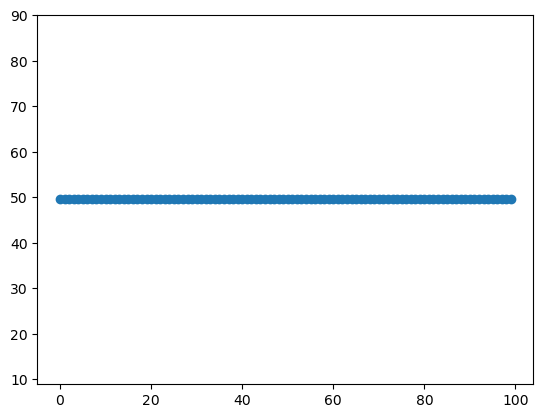

In [53]:
plt.plot(data['x'], data['y'], 'o')
_ = plt.axis('equal')

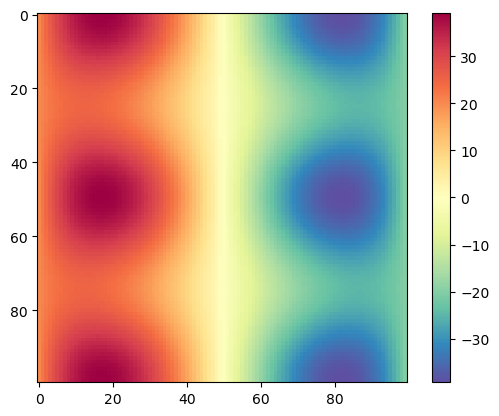

In [59]:
plt.imshow(z, cmap='Spectral_r')
plt.colorbar()

It doesn't work because the method assumes an image as input no an actual 3d envelope!